This exercise is based on the MATLAB implementation of LC2. The goal here is to become familiar with registration of
CT-US images. First we try LC2 on one sample image and compare it to SSD.
Then we evaluate LC2 and SSD on registration of a pair of CT-US images.

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from skimage.transform import resize
%matplotlib inline

Load the phantom image and resize

In [2]:
img = imageio.imread('../data/SheppLogan_Phantom.png')
img = color.rgb2gray(img)
img = resize(img, (200, 200))

/var/folders/26/hjkpxhf97ybcgwp64rkjy8rc0000gp/T/ipykernel_89042/1368550726.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/SheppLogan_Phantom.png')


Add noise to the phantom image to make the moving image

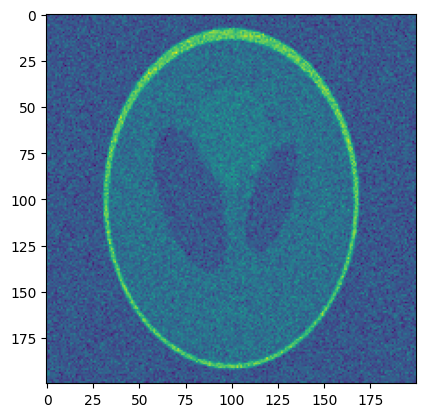

In [3]:
img1 = img + np.random.normal(0, 0.15, img.shape)
plt.imshow(img1)

Stack the gradient of the second image

In [4]:
from skimage import filters
edges = filters.sobel(img)
img2 = np.stack((img, edges), axis=2)

First, We define the global LC2 metric. The gaol is to find the coefficients that best simulates the first image
(later the US image) given the second image (later the CT image). The simulation is assumed a linear function of
intensity and gradient of the second image.

In [5]:
def LC2Similarity(img1, img2):
    similarity, weight, measure = -1, 0, 0

    num = img1.shape[0] * img2.shape[1]
    ids = img1 > 0
    v1 =  np.var(img1[ids])

    if v1 > 1e-12:
        if np.sum(ids) > num/2:
            img2r = np.concatenate((np.reshape(img2, (num, img2.shape[2])), np.ones((num, 1))), axis=1)
            pimg2r = np.linalg.pinv(img2r[ids.flatten(), :])
            parameter = np.matmul(pimg2r, img1[ids])
            similarity = 1 - (np.var(img1[ids] - (np.matmul(img2r[ids.flatten(), :], parameter))) / v1)
            weight = np.sqrt(v1)
            measure = weight * similarity
    if similarity == -1:
        similarity = 0

    return similarity, measure, weight

Test against rotation

Text(0, 0.5, 'similarity')

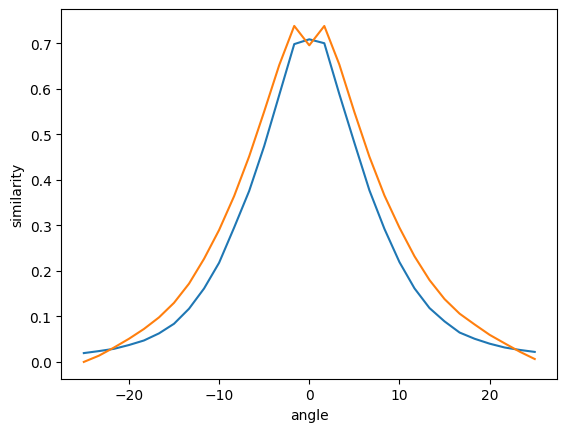

In [6]:
# constants:
ang_range = 25
ang_bins = 31
tra_range = 11
tra_step_size = 1

from scipy.ndimage import rotate
angles = np.linspace(-ang_range, ang_range, ang_bins)
sims_lc2 = []
sims_ssd = []
for angle in angles:
    img1_r = rotate(img1, angle, reshape=False)
    similarity, _, _ = LC2Similarity( img1_r, img2 )
    sims_lc2.append(similarity)
    sims_ssd.append(np.sum((img1_r - img)**2))

sims_ssd = 1 - sims_ssd/np.max(sims_ssd)
plt.plot(angles, sims_lc2)
plt.plot(angles, sims_ssd)
plt.xlabel('angle')
plt.ylabel('similarity')

Test against translation

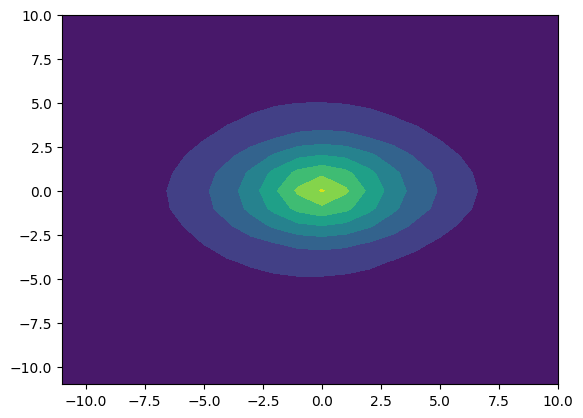

In [7]:
from scipy.ndimage import affine_transform
affine = np.eye(3)
sims = []

grid_x, grid_y = np.mgrid[-tra_range:tra_range:tra_step_size, -tra_range:tra_range:tra_step_size]

for x, y in zip(grid_x.flatten(), grid_y.flatten()):
    affine[0, 2] = x
    affine[1, 2] = y
    img1_t = affine_transform(img1, affine)
    similarity, _, _ = LC2Similarity(img1_t, img2)
    sims.append(similarity)

sims = np.reshape(sims, grid_x.shape)
h = plt.contourf(grid_x, grid_y, sims)


As can be seen from the graphs, our global LC2 reaches its maximum value on the correct alignment. For the phantom image,
SSD also reaches its extremum on the correct alignment.

Now, we move to a pair of US-CT images. First we load the two image and pre-calculate the gradient of the second image.

/var/folders/26/hjkpxhf97ybcgwp64rkjy8rc0000gp/T/ipykernel_89042/3428996621.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread('../data/Ultrasound_slice.png')


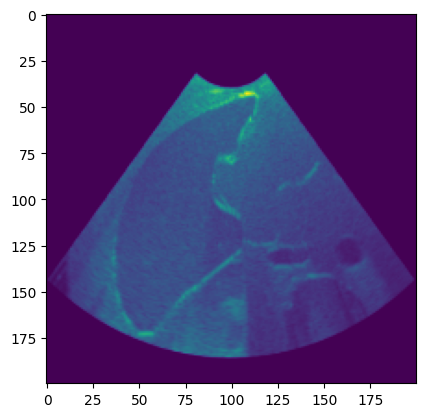

In [10]:
img1 = imageio.imread('../data/Ultrasound_slice.png')
img1 = resize(img1, (200, 200))
plt.imshow(img1)

/var/folders/26/hjkpxhf97ybcgwp64rkjy8rc0000gp/T/ipykernel_89042/1671710553.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/CT_slice.png')


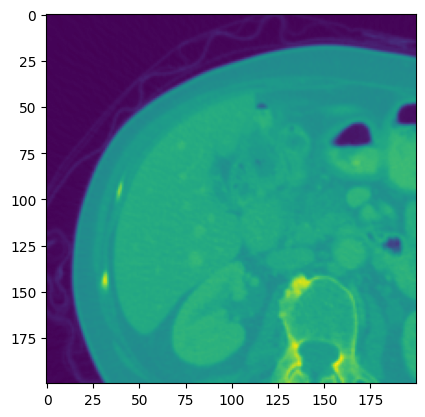

In [12]:
img = imageio.imread('../data/CT_slice.png')
img = resize(img, (200, 200))
plt.imshow(img)

from skimage import filters
edges = filters.sobel(img)
img2 = np.stack((img, edges), axis=2)

Now we test against rotation and translation as before and compare it to SSD.

Text(0, 0.5, 'similarity')

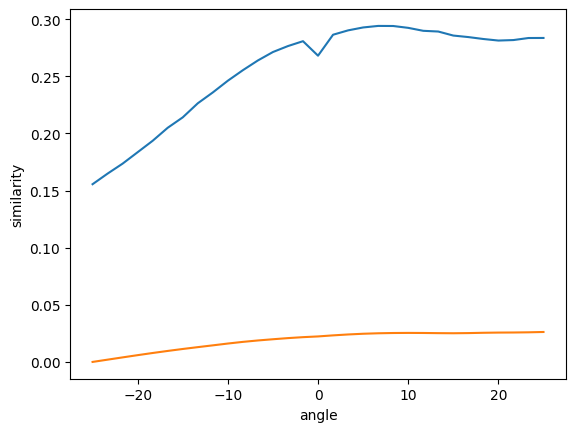

In [13]:
from scipy.ndimage import rotate
angles = np.linspace(-ang_range, ang_range, ang_bins)
sims_lc2 = []
sims_ssd = []
for angle in angles:
    img1_r = rotate(img1, angle, reshape=False)
    similarity, _, _ = LC2Similarity( img1_r, img2 )
    sims_lc2.append(similarity)
    sims_ssd.append(np.sum((img1_r - img)**2))

sims_ssd = 1 - sims_ssd/np.max(sims_ssd)
plt.plot(angles, sims_lc2)
plt.plot(angles, sims_ssd)
plt.xlabel('angle')
plt.ylabel('similarity')

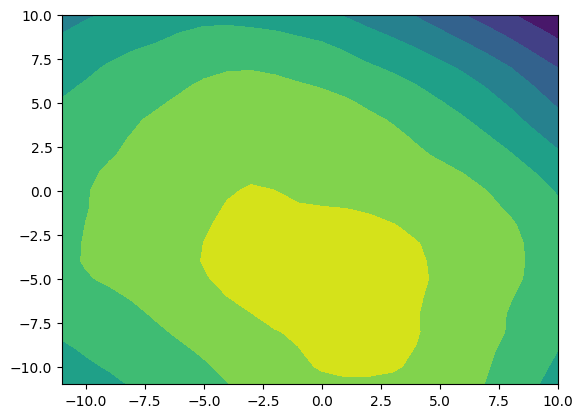

In [14]:
from scipy.ndimage import affine_transform
affine = np.eye(3)
sims = []

grid_x, grid_y = np.mgrid[-tra_range:tra_range:tra_step_size, -tra_range:tra_range:tra_step_size]

for x, y in zip(grid_x.flatten(), grid_y.flatten()):
    affine[0, 2] = x
    affine[1, 2] = y
    img1_t = affine_transform(img1, affine)
    similarity, _, _ = LC2Similarity(img1_t, img2)
    sims.append(similarity)

sims = np.reshape(sims, grid_x.shape)
h = plt.contourf(grid_x, grid_y, sims)

While SSD is failing, our global LC2 is showing a

For the next part your task is to write the code for patch-wise LC2 using the one we already created.

In [15]:
def LC2SimilarityPatch(img1, img2, patchsize):
    max_x = img1.shape[0]
    max_y = img1.shape[1]
    min_size = ((2*patchsize+1)^2)/2
    measure = np.zeros(img1.shape)
    weights = np.zeros(img1.shape)

    for y in np.arange(0, max_y, step=patchsize):
        for x in np.arange(0, max_x, step=patchsize):
            x_min = np.max([0, x - patchsize])
            x_max = np.min([max_x - 1, x + patchsize])
            y_min = np.max([1, y - patchsize])
            y_max = np.min([max_y - 1, y + patchsize])
            patch1 = img1[x_min: x_max, y_min: y_max]
            patch2 = img2[x_min: x_max, y_min: y_max, :]

            if np.size(patch1) > min_size:
                _, measure[x,y], weights[x,y] = LC2Similarity(patch1, patch2)

    # similarity = np.zeros([mea.shape[2], 1])

    similarity = np.nansum(measure) / np.nansum(weights)
    return similarity

/Users/farid/opt/miniconda3/envs/camp1_exercise/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/farid/opt/miniconda3/envs/camp1_exercise/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/farid/opt/miniconda3/envs/camp1_exercise/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'similarity')

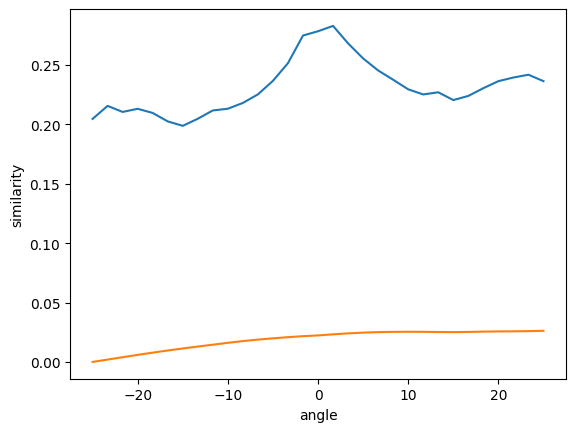

In [16]:

from scipy.ndimage import rotate
angles = np.linspace(-ang_range, ang_range, ang_bins)
sims_lc2 = []
sims_ssd = []
for angle in angles:
    img1_r = rotate(img1, angle, reshape=False)
    similarity = LC2SimilarityPatch( img1_r, img2, patchsize=5)
    sims_lc2.append(similarity)
    sims_ssd.append(np.sum((img1_r - img)**2))

sims_ssd = 1 - sims_ssd/np.max(sims_ssd)
plt.plot(angles, sims_lc2)
plt.plot(angles, sims_ssd)
plt.xlabel('angle')
plt.ylabel('similarity')

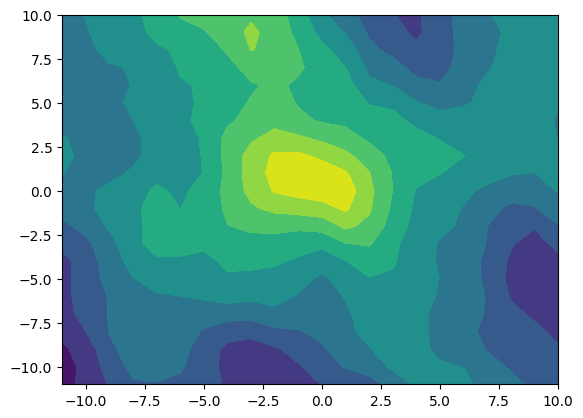

In [17]:
from scipy.ndimage import affine_transform
affine = np.eye(3)
sims = []

grid_x, grid_y = np.mgrid[-tra_range:tra_range:tra_step_size, -tra_range:tra_range:tra_step_size]

for x, y in zip(grid_x.flatten(), grid_y.flatten()):
    affine[0, 2] = x
    affine[1, 2] = y
    img1_t = affine_transform(img1, affine)
    similarity = LC2SimilarityPatch(img1_t, img2, patchsize=5)
    sims.append(similarity)

sims = np.reshape(sims, grid_x.shape)
h = plt.contourf(grid_x, grid_y, sims)